Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7861 entries, 0 to 7860
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   G       7861 non-null   int64  
 1   C       7861 non-null   int64  
 2   B       7861 non-null   int64  
 3   A       7861 non-null   int64  
 4   Ia      7861 non-null   float64
 5   Ib      7861 non-null   float64
 6   Ic      7861 non-null   float64
 7   Va      7861 non-null   float64
 8   Vb      7861 non-null   float64
 9   Vc      7861 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 614.3 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12001 entries, 0 to 12000
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Output (S)  12001 non-null  int64  
 1   Ia          12001 non-null  float64
 2   Ib          12001 non-null  float64
 3   Ic          12001 non-null  float64
 4   Va          12001

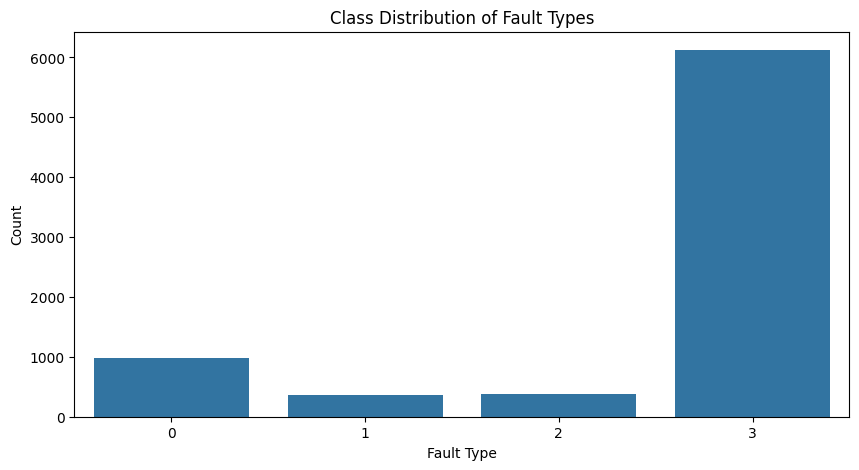

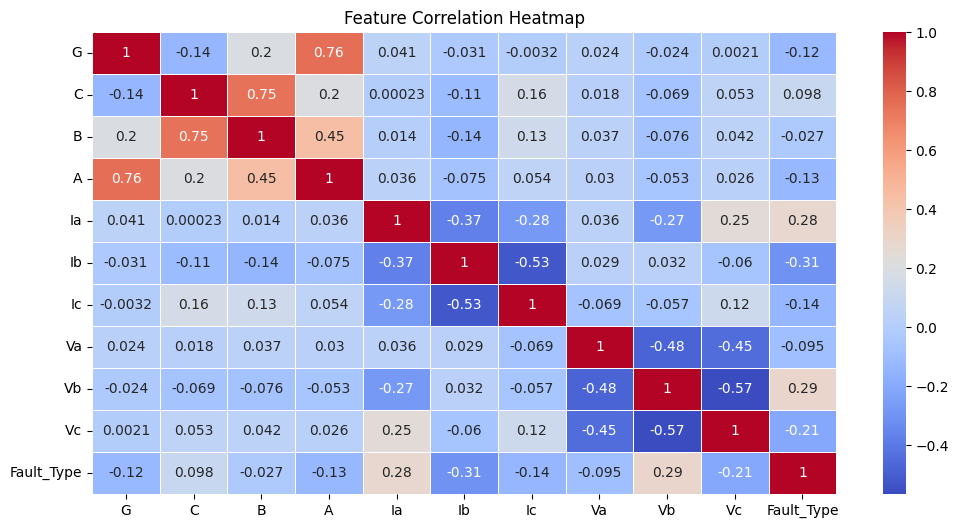


Training Logistic Regression Model...
Logistic Regression - Classification Report:               precision    recall  f1-score   support

           0       0.88      0.90      0.89       197
           1       0.90      0.96      0.93        74
           2       0.84      0.96      0.90        77
           3       0.98      0.96      0.97      1225

    accuracy                           0.95      1573
   macro avg       0.90      0.95      0.92      1573
weighted avg       0.96      0.95      0.96      1573

Accuracy Score: 0.9548633184996821

Training Random Forest Classifier...
Random Forest - F1 Score: 0.996789883058951
Accuracy Score: 0.9968213604577241


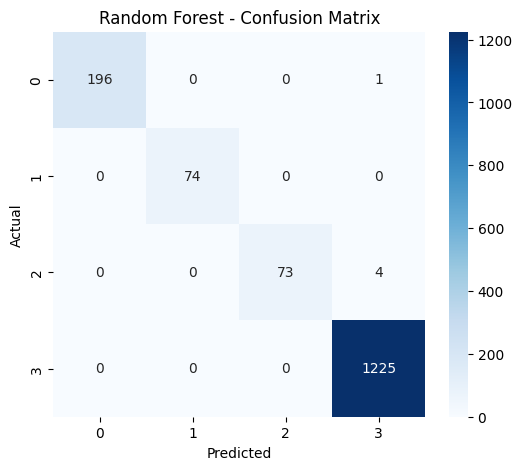


Training XGBoost Classifier...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:37:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - F1 Score: 0.9993635929648678
Accuracy Score: 0.9993642720915448


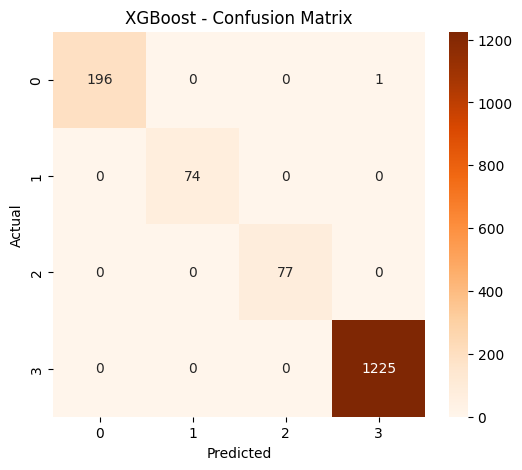

Model training and evaluation complete.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

# Load datasets
df_class = pd.read_csv("/content/classData.csv")
df_detect = pd.read_csv("/content/detect_dataset.csv")

# Display basic dataset info
print("Dataset Information:")
df_class.info()
df_detect.info()

print("\nFirst 5 rows of class dataset:")
print(df_class.head())

print("\nFirst 5 rows of detect dataset:")
print(df_detect.head())

# Define labeling rules based on current and voltage levels
def label_faults(row):
    # Check if 'In' column exists, if not, assume it's 0 for this dataset
    in_value = row['In'] if 'In' in row else 0

    conditions = (row['Ia'] > 0, row['Ib'] > 0, row['Ic'] > 0, in_value > 0)
    label_mapping = {
        (0, 0, 0, 0): 'No Fault',
        (1, 0, 0, 1): 'LG',
        (0, 1, 1, 0): 'LL',
        (1, 0, 1, 1): 'LLG',
        (1, 1, 1, 0): 'LLL',
        (1, 1, 1, 1): 'LLLG'
    }
    return label_mapping.get(conditions, 'Unknown')

# Apply labeling to both datasets
df_class['Fault_Type'] = df_class.apply(label_faults, axis=1)
df_detect['Fault_Type'] = df_detect.apply(label_faults, axis=1)
df = df_class.copy()

# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values per Column:", missing_values)

# Handling missing values
if missing_values.sum() > 0:
    missing_threshold = 10
    if missing_values.sum() < missing_threshold:
        imputer = SimpleImputer(strategy='median')
    else:
        imputer = KNNImputer(n_neighbors=5)
    df.iloc[:, :] = imputer.fit_transform(df)
    print("Missing values handled successfully.")

# Encode categorical variables
le = LabelEncoder()
df['Fault_Type'] = le.fit_transform(df['Fault_Type'])

# Splitting features and target
X = df.drop(columns=['Fault_Type'])
y = df['Fault_Type']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 5))
sns.countplot(x=y)
plt.title("Class Distribution of Fault Types")
plt.xlabel("Fault Type")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Baseline Model: Logistic Regression
print("\nTraining Logistic Regression Model...")
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression - Classification Report:", classification_report(y_test, y_pred_lr))
print("Accuracy Score:", accuracy_score(y_test, y_pred_lr))

# Random Forest Classifier
print("\nTraining Random Forest Classifier...")
rf = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=4)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest - F1 Score:", f1_score(y_test, y_pred_rf, average='weighted'))
print("Accuracy Score:", accuracy_score(y_test, y_pred_rf))
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# XGBoost Classifier
print("\nTraining XGBoost Classifier...")
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=200, learning_rate=0.01)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost - F1 Score:", f1_score(y_test, y_pred_xgb, average='weighted'))
print("Accuracy Score:", accuracy_score(y_test, y_pred_xgb))
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Oranges')
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Model training and evaluation complete.")